# Image Prediction Models

This notebook contains the models that we will use to predict stocks using images.

Here we are using two models:
1. CNN2d
2. ResNet50

Importing relevant libraries

In [36]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.applications import ResNet50
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [37]:
# Define the file path for the image.
image_path = "/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI/BBAS3.SA/imagens/teste/comprar/2019-04-29_1.png"

# Open the image using the PIL library.
image = Image.open(image_path)

# Get the image dimensions (width, height).
width, height = image.size

# Create a tuple with dimensions swapped (height, width) if needed.
img_size = (height, width)

# Print out the image dimensions.
print(f"Image size: {width}x{height} pixels")

Image size: 100x333 pixels


Defining training parameters.

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-6

#### Data Loading and Preprocessing

Prepares image datasets as follows:

- **Setup:**  
  Defines the base data directory, a list of stock symbols, and the target image size.

- **Dataset Loading:**  
  Implements the `load_dataset` function which uses TensorFlow's `image_dataset_from_directory` to load images from specific directories. It supports loading training, validation, and test datasets with an optional validation split.

- **Dataset Concatenation:**  
  Iterates over each stock, loads the corresponding datasets, and concatenates them into unified training, validation, and test datasets. The class names are captured from the first dataset loaded.

- **Preprocessing:**  
  Applies a ResNet50-specific preprocessing function (`resnet_preprocess`) that casts images to `float32` and normalizes them appropriately.

- **Optimization:**  
  Uses TensorFlow's `prefetch` to optimize data loading performance during model training and evaluation.


In [38]:
# Set the base data directory, stock symbols, and target image size.
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA']
img_size = (224, 224)

# Define a function to load an image dataset for a given stock.
def load_dataset(stock, subset, data_type="treino", seed=123):
    # Build the path to the images directory.
    stock_image_dir = os.path.join(data_dir, stock, "imagens", data_type)
    
    # Load images from the directory into a TensorFlow dataset.
    return tf.keras.utils.image_dataset_from_directory(
        stock_image_dir,
        validation_split=0.2 if subset != "test" else None,
        subset=subset if subset != "test" else None,
        seed=seed,
        image_size=img_size,
        batch_size=BATCH_SIZE,
        label_mode="categorical"
    )

# Initialize variables for accumulating training, validation, and test datasets.
total_train_ds = None
total_val_ds = None
total_test_ds = None
class_names = None

# Loop through each stock to load and combine their datasets.
for stock in stocks:
    print(f'Carregando dados para {stock}...')
    
    print("Dados de Treino")
    train_ds = load_dataset(stock, "training")
    val_ds = load_dataset(stock, "validation")
    
    print("Dados de Teste")
    test_ds = load_dataset(stock, "test", data_type="teste")
    
    # Concatenate the training datasets.
    if total_train_ds is None:
        total_train_ds = train_ds
        class_names = train_ds.class_names
    else:
        total_train_ds = total_train_ds.concatenate(train_ds)
    
    # Concatenate the validation datasets.
    if total_val_ds is None:
        total_val_ds = val_ds
    else:
        total_val_ds = total_val_ds.concatenate(val_ds)
    
    # Concatenate the test datasets.
    if total_test_ds is None:
        total_test_ds = test_ds
    else:
        total_test_ds = total_test_ds.concatenate(test_ds)

print("Datasets concatenados com sucesso!")
print("Classes disponíveis:", class_names)

# Define a preprocessing function to normalize images for ResNet50.
def resnet_preprocess(images, labels):
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    return images, labels

# Map the preprocessing function to the datasets.
total_train_ds = total_train_ds.map(resnet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
total_val_ds   = total_val_ds.map(resnet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
total_test_ds  = total_test_ds.map(resnet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch the datasets to enhance performance during training and evaluation.
total_train_ds = total_train_ds.prefetch(tf.data.AUTOTUNE)
total_val_ds   = total_val_ds.prefetch(tf.data.AUTOTUNE)
total_test_ds  = total_test_ds.prefetch(tf.data.AUTOTUNE)


Carregando dados para BBAS3.SA...
Dados de Treino
Found 4735 files belonging to 2 classes.
Using 3788 files for training.
Found 4735 files belonging to 2 classes.
Using 947 files for validation.
Dados de Teste
Found 1185 files belonging to 2 classes.
Carregando dados para CSNA3.SA...
Dados de Treino
Found 4743 files belonging to 2 classes.
Using 3795 files for training.
Found 4743 files belonging to 2 classes.
Using 948 files for validation.
Dados de Teste
Found 1186 files belonging to 2 classes.
Carregando dados para PETR4.SA...
Dados de Treino
Found 4808 files belonging to 2 classes.
Using 3847 files for training.
Found 4808 files belonging to 2 classes.
Using 961 files for validation.
Dados de Teste
Found 1203 files belonging to 2 classes.
Carregando dados para VALE3.SA...
Dados de Treino
Found 3268 files belonging to 2 classes.
Using 2615 files for training.
Found 3268 files belonging to 2 classes.
Using 653 files for validation.
Dados de Teste
Found 1203 files belonging to 2 class

Visualizing shapes and class names.

In [39]:
for images, labels in total_train_ds.take(1):
    print(images.shape, labels.shape)

class_names = train_ds.class_names
print(class_names)

(32, 224, 224, 3) (32, 2)
['comprar', 'vender']


Visualizing sample images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


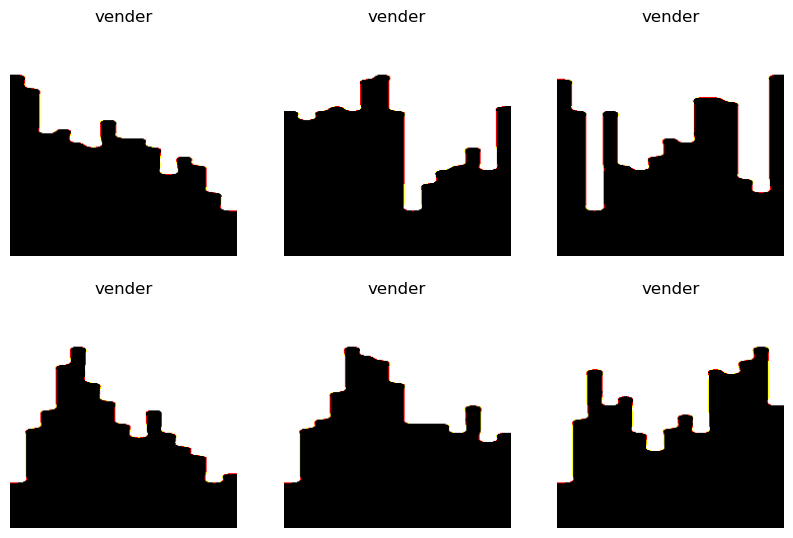

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in total_train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
plt.show()

Define history ploting method.

In [40]:
def plot_training_history(history):
    """
    Plots training & validation accuracy and loss from a Keras model history.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model.fit()
    """
    history_dict = history.history

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss', color='blue')
    plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

## Models

### CNN2d  Model.

In [ ]:
# Determine the number of classes based on the available class names
num_classes = len(class_names)

# Define the CNN model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),    # Normalize input images
    layers.Conv2D(16, 3, padding='same', activation='relu'),                # Conv layer with 16 filters
    layers.MaxPooling2D(),                                                  # Reduce spatial dimensions
    layers.Conv2D(32, 3, padding='same', activation='relu'),                # Conv layer with 32 filters
    layers.MaxPooling2D(),                                                  # Reduce spatial dimensions
    layers.Conv2D(64, 3, padding='same', activation='relu'),                # Conv layer with 64 filters
    layers.MaxPooling2D(),                                                  # Reduce spatial dimensions
    layers.Flatten(),                                                       # Flatten feature maps into 1D vector
    layers.Dense(32, activation='relu'),                                    # Dense layer with 32 units
    layers.Dense(num_classes)                                               # Output layer: one neuron per class (logits)
])

# Compile the model with Adam optimizer and categorical crossentropy loss (using logits)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model on the training dataset and validate using val_ds for the specified number of epochs
history = model.fit(
    total_train_ds,          # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=EPOCHS           # Number of training epochs
)


/home/mark/anaconda3/envs/sandbox/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,314 (6.22 MB)

 Trainable params: 1,629,314 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
387/441 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8361 - loss: 0.3673

2025-02-20 18:54:26.258494: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 36 bytes spill stores, 36 bytes spill loads



441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8418 - loss: 0.3555 - val_accuracy: 0.8867 - val_loss: 0.2536
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8904 - loss: 0.2622 - val_accuracy: 0.8867 - val_loss: 0.2707
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8956 - loss: 0.2440 - val_accuracy: 0.8851 - val_loss: 0.2874
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8960 - loss: 0.2368 - val_accuracy: 0.8407 - val_loss: 0.2857
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8996 - loss: 0.2332 - val_accuracy: 0.8836 - val_loss: 0.2594
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9020 - loss: 0.2186 - val_accuracy: 0.9081 - val_loss: 0.2614
Epoch 7/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9129 - loss: 0.2016 - val_accuracy: 0.8943 - val_loss: 0.2594
Epoch 8/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9230 - loss: 0.1830 - val_accuracy: 0.8714 - val

Plotting CNN2d Model's training history.

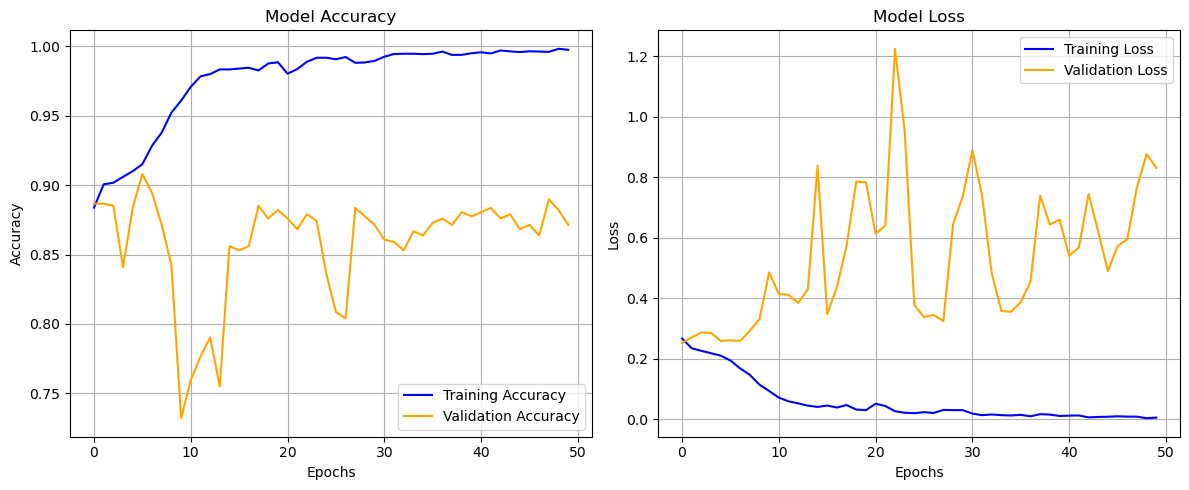

In [42]:
plot_training_history(history)


Evaluates CNN2d Model.

In [44]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(total_test_ds)  
print(f'Test accuracy: {accuracy:.4f}')

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8551 - loss: 1.8803
Test accuracy: 0.8426


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

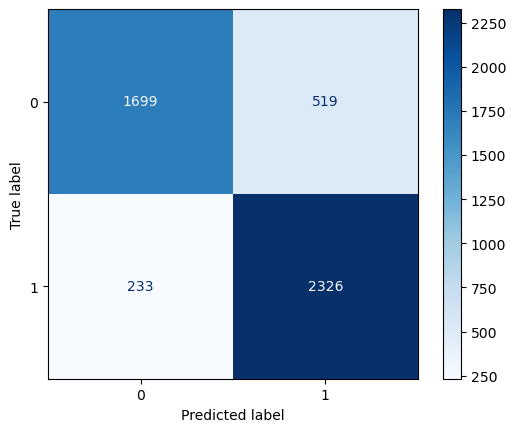


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


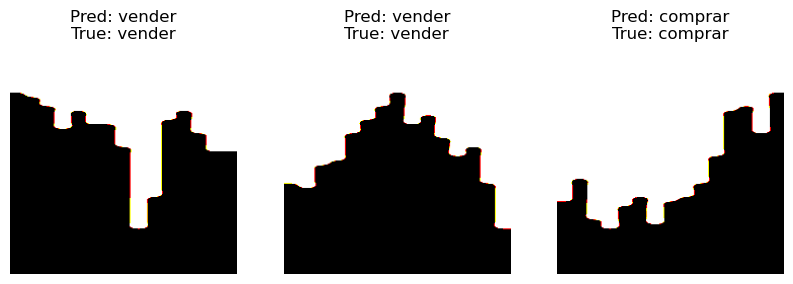

In [45]:
# Obtain predictions and true labels
y_true = []
y_pred = []

for images, labels in total_test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print evaluation results
print(f"Model: {model.__class__}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print("Confusion matrix:")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print()

# Make predictions on the test set
plt.figure(figsize=(10, 10))
for images, labels in total_test_ds.take(1):
    predictions = model.predict(images)
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        predicted_class = class_names[tf.argmax(predictions[i]).numpy()]
        true_class = class_names[tf.argmax(labels[i]).numpy()]
        plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
        plt.axis("off")
plt.show()


### ResNet50 Model.

In [15]:
# Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze initial layers and fine-tune top layers
for layer in base_model.layers[:-1]:  # Fine-tune only last 10 layers
    layer.trainable = False

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)

# Create Model
model_resnet = Model(inputs=base_model.input, outputs=output)

# Compile Model
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_resnet = model_resnet.fit(
    total_train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    # callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.4837 - loss: 1.6503 - val_accuracy: 0.8208 - val_loss: 0.5088
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5292 - loss: 1.2739 - val_accuracy: 0.8224 - val_loss: 0.5109
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5396 - loss: 1.2352 - val_accuracy: 0.8239 - val_loss: 0.5066
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5352 - loss: 1.1716 - val_accuracy: 0.8239 - val_loss: 0.5092
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5431 - loss: 1.1049 - val_accuracy: 0.8239 - val_loss: 0.5035
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5472 - loss: 1.0448 - val_accuracy: 0.8224 - val_loss: 0.4991
Epoch 7/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5655 - loss: 0.9730 - val_accuracy: 0.8224 - val_loss: 0.4915
Epoch 8/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5566 - loss: 0.9395 - val_acc

Plotting ResNet50 Model's training history.

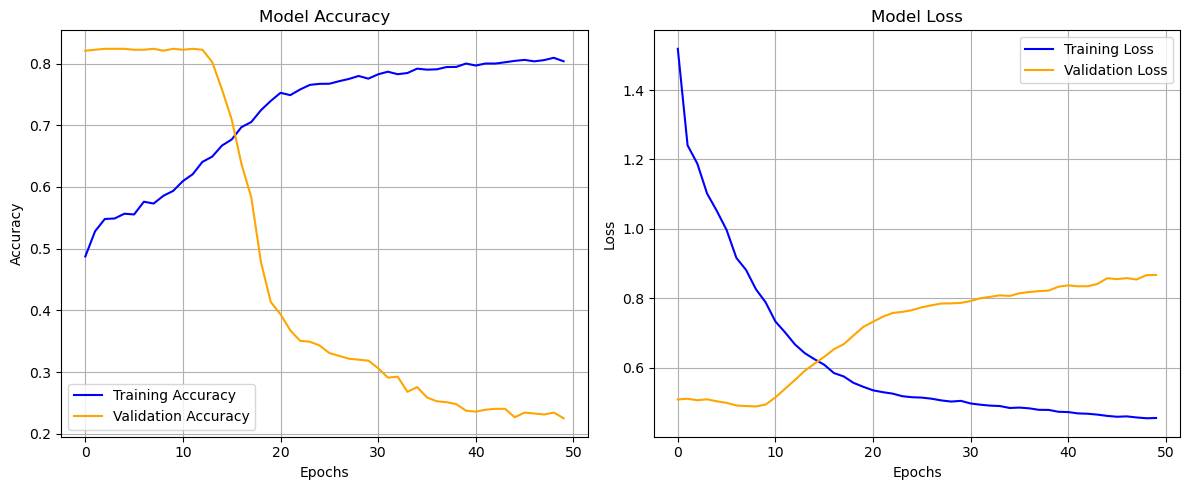

In [43]:
plot_training_history(history_resnet)

Evaluates ResNet50 Model.

In [46]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(total_test_ds)  
print(f'Test accuracy: {accuracy:.4f}')

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8555 - loss: 1.8919
Test accuracy: 0.8426


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


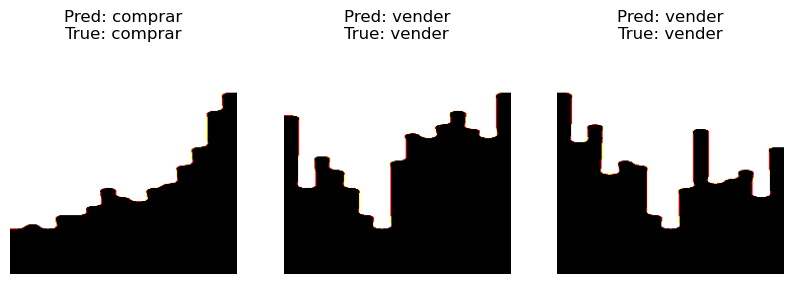

In [ ]:
# Make predictions on the test set
plt.figure(figsize=(10, 10))
for images, labels in total_test_ds.take(1):
    predictions = model_resnet.predict(images)
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        predicted_class = class_names[tf.argmax(predictions[i]).numpy()]
        true_class = class_names[tf.argmax(labels[i]).numpy()]
        plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
        plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

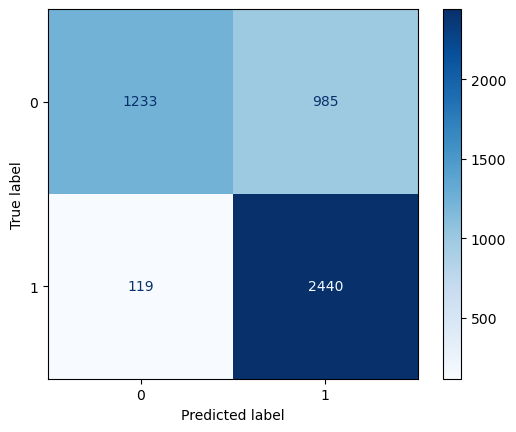


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


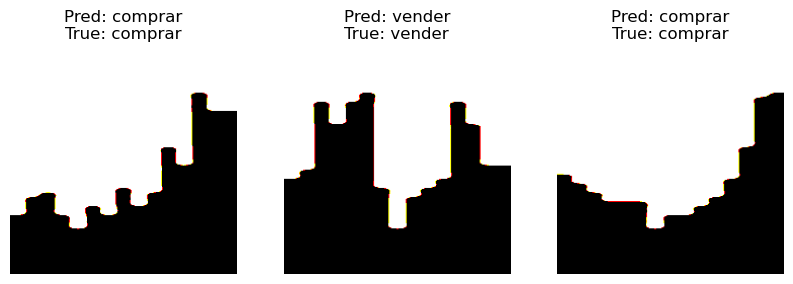

In [47]:
# Obtain predictions and true labels
y_true = []
y_pred = []

for images, labels in total_test_ds:
    predictions = model_resnet.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print evaluation results
print(f"Model: {model_resnet.__class__}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print("Confusion matrix:")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print()

# Make predictions on the test set
plt.figure(figsize=(10, 10))
for images, labels in total_test_ds.take(1):
    predictions = model_resnet.predict(images)
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        predicted_class = class_names[tf.argmax(predictions[i]).numpy()]
        true_class = class_names[tf.argmax(labels[i]).numpy()]
        plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
        plt.axis("off")
plt.show()
